# The Differentiable Cross-Entropy Method: Examples

This notebook is by
[Brandon Amos](http://bamos.github.io)
and
[Denis Yarats](https://cs.nyu.edu/~dy1042/)
and provides code examples for using our `dcem` library.
We provide an implementation of
[the vanilla cross-entropy method](http://web.mit.edu/6.454/www/www_fall_2003/gew/CEtutorial.pdf) (CEM)
for optimization of a continuous function and our differentiable extensions.
More details can be found in our ICML 2020 paper on
[the differentiable cross-entropy method](https://arxiv.org/abs/1909.12830) (DCEM).

This notebook contains two main examples of our code:
1. We optimize a simple *parameterized* 2D function
   with CEM, and then show how to use DCEM to update
   the parameterization to move the minimum
2. We optimize a simple control problem with CEM

We have posted source code behind the regression and control experiments in
our paper in the
[exps](https://github.com/facebookresearch/dcem/tree/main/exps) directory.

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

import os
import shutil

# From https://github.com/locuslab/mpc.pytorch/tree/master/mpc
from mpc.env_dx.pendulum import PendulumDx

%load_ext autoreload
%autoreload 2
from dcem import dcem, dcem_ctrl

%matplotlib inline

# Optimization with the vanilla cross-entropy method

We start by showing how to use CEM to optimize a simple 2D
function composed of three *parameterized* exponential
functions. In this section we keep the parameters fixed
and in the next section we show how to use our differentiable
variant to update the parameters to optimize a downstream loss.

In [2]:
# Get the objective given a parameterization of the objective
def get_obj(params):
    # Batched PyTorch implementation of the objective
    def f(XY):
        X, Y = torch.split(XY, [1,1], dim=-1)
        Z = 0.
        for i in range(len(params)//3):
            Z -= params[3*i]*torch.exp(-(X-params[3*i+1])**2 - (Y-params[3*i+2])**2)
        Z += 0.15*X*torch.cos(Y)
        return Z.squeeze(-1)
    
    # Batched numpy interface of the objective for plotting that
    # calls into the PyTorch version
    def f_np(X, Y):
        XY = np.concatenate((np.expand_dims(X, -1), np.expand_dims(Y, -1)), -1)
        XY = torch.from_numpy(XY)
        Z = f(XY).detach().numpy()
        return Z
    return f, f_np

Initialize a fixed parameterization, retrieve the objective, and plot
out the function that we will be optimizing.
The lighter regions of this plot show lower function values and
we are interested in methods that minimize the function and
find the optimum in the lower-right.

(-3.0, 1.0, -1.0, 3.0)

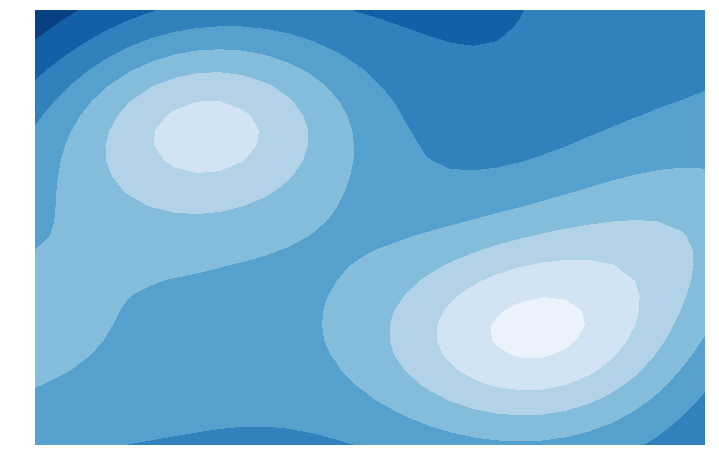

In [3]:
init_params = torch.Tensor([1., 0., 0., 0.5, 1., 1., 1., -2., 2.])
f, f_np = get_obj(init_params)

N = 30
x = np.linspace(-3.0, 1.0, N)
y = np.linspace(-1.0, 3.0, N)
X, Y = np.meshgrid(x, y)
Z = f_np(X, Y)

fig, ax = plt.subplots(figsize=(12,8))
CS = ax.contourf(X, Y, Z, cmap='Blues')
ax.axis('off')

Optimize the function with CEM and plot out the samples and
make them progressively darker as CEM progresses.
We see that CEM starts with a large normal distribution and
refines it and is able finds the optimum.

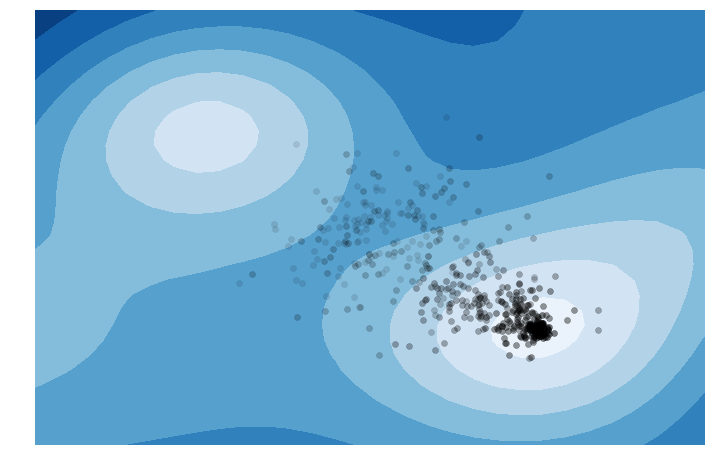

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlim(-3, 1.)
ax.set_ylim(-1, 3.)

CS = ax.contourf(X, Y, Z, cmap='Blues')
ax.axis('off')

# dcem provides information to this callback after every iteration
# Here we use it to plot out the samples
n_iter = 10
def iter_cb(i, X, fX, I, X_I, mu, sigma):
    ax.scatter(X[0,:,0].detach(), X[0,:,1].detach(), color='k', alpha=(i+1.)/n_iter)

# Optimize the function
torch.manual_seed(0)
opt = dcem(
    f=f, # Objective to optimize
    nx=2, # Number of dimensions to optimize over
    n_batch=1, # Number of elements in the batch
    init_mu=torch.Tensor([[-1., 1]]), # Initial mean
    init_sigma=0.3, # Initial variance
    n_sample=100, # Number of samples CEM uses in each iteration
    n_elite=10, # Number of elite CEM candidates in each iteration
    n_iter=n_iter, # Number of CEM iterations
    temp=None, # DCEM temperature parameter, None here uses vanilla CEM
    iter_cb=iter_cb, # Iteration callback
)

# Using the differentiable cross-entropy method (DCEM) to update the objective's parameterization

Next, we will show how to use downstream task information to update
the objective's parameterization by seeing the cross-entropy method
as another end-to-end learnable component that we can compute
derivatives through.
This is useful in the machine learning setting when the objective uses
a non-trivial model and we want to update the parameters of the model
so it induces an optimization problem that optimally performs a
downstream task.

In the standard machine learning setting, we typically optimize our
models to maximize the data likelihood and we then *hope* that plugging
these models into a larger system induces reasonable performance for
this downstream task we care about.
There is *no guarantee* that the maximum likelihood model will attain
the optimal task performance, as discussed in our paper and the
references therein, such as
[Task-based End-to-end Model Learning in Stochastic Optimization](https://arxiv.org/abs/1703.04529)
or
[Objective Mismatch in Model-based Reinforcement Learning](https://arxiv.org/abs/2002.04523).
For example, if we are training an image classification model for use in
autonomous driving, the maximum likelihood solution will not have
the information of what errors are not important (e.g. dog vs cat)
compared to what errors are extremely important
(e.g. traffic signals, pedestrians, other moving objects).
The differentiable cross-entropy method enables this downstream
task information to be provided to the model's derivatives when
we can solve our downstream task with CEM.

We show a simple starter differentiable optimization example here to
convey intuitions that updates our 2D objective's
parameterization to make the minimum at a desired location.
We can enable CEM derivatives with minimal modifications to our
previous use of CEM by setting the temperature parameter `temp`.
Here, we exclusively use the DCEM gradients to update the parameters.
In practice, DCEM can be mixed with other gradient signals and
can be seen as more of a fine-tuning step.

In [5]:
# Helper function to plot out the most recent objective.
def plot_surface_and_opt(f_np, desired_opt, pred_opt, i):
    N = 30
    x = np.linspace(-3.0, 1.0, N)
    y = np.linspace(-1.0, 3.0, N)
    X, Y = np.meshgrid(x, y)
    Z = f_np(X, Y)

    fig, ax = plt.subplots(figsize=(12,8))
    CS = ax.contourf(X, Y, Z, cmap='Blues')

    ax.set_xlim(-3, 1.)
    ax.set_ylim(-1, 3.)
    ax.axis('off')

    plt.plot(*desired_opt.detach().numpy().tolist(), marker='*',
             markersize=25, color='#A60628')
    fname = f'plots/{i:04d}.png'
    fig.savefig(fname)
    os.system(f'convert {fname} -trim {fname}')
    plt.close(fig)

This next part contains our main learning loop that iteratively updates
the parameters to optimize the squared Euclidean distance between the
current optimum and our desired one.

In [6]:
torch.manual_seed(0)

# Clean the plot directory
shutil.rmtree('plots', ignore_errors=True)
os.makedirs('plots', exist_ok=True)

# Initialize the learnable parameters and get the objective connected to them
params = init_params.clone().requires_grad_()
f, f_np = get_obj(params)

opt = torch.optim.RMSprop([params], lr=1e-2, momentum=0.1)
desired_opt = torch.Tensor([0, 1.25]) # Move the optimum to this location
losses = []

for i in range(50):
    # Use the same CEM configuration as before except enable
    # the derivatives with the temp option.
    pred_opt = dcem(
        f=f,
        nx=2,
        n_batch=1,
        init_mu=torch.Tensor([[-1., 1]]),
        init_sigma=0.3,
        n_sample=100,
        n_elite=10,
        n_iter=10,
        temp=1., # Enable the derivatives
    )
    pred_opt = pred_opt.squeeze()
    assert pred_opt.shape == desired_opt.shape
    
    # The loss is the squared Euclidean distance from the current argmin
    # to what we want it to be
    loss = (pred_opt - desired_opt).pow(2).mean()
    losses.append(loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    plot_surface_and_opt(f_np, desired_opt, pred_opt, i)

We can plot out the loss over iterations and see that in ~50 iterations we can successfully move the optimum.

Text(0.5, 1.0, 'MSE Loss')

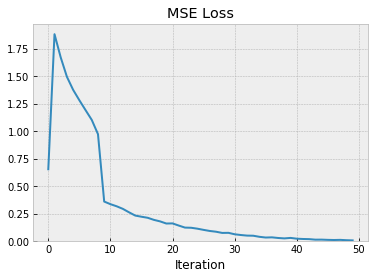

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(losses)
ax.set_ylim(0)
ax.set_xlabel('Iteration')
ax.set_title('MSE Loss')

In [8]:
os.system('convert plots/*.png +repage learning.gif')
from IPython.display import Image
Image(url='learning.gif')  

# Model-Based Control with the Cross-Entropy Method

CEM is a state-of-the-art optimizer for model-based control,
such as in
[PETS](http://papers.nips.cc/paper/7725-deep-reinforcement-learning-in-a-handful-of-trials-using-probabilistic-dynamics-models)
and [PlaNet](http://proceedings.mlr.press/v97/hafner19a.html).
We provide a lightweight `dcem_ctrl` interface to make
model-based control applications easier.

We show a simple example of controlling a pendulum system
with vanilla CEM to provide a starting point for CEM-based control.
The cost here is the squared Euclidean distance of the pendulum's
state to the upright position.
We are able to minimize the controller's cost and can visualize
the optimal state and control sequences CEM has found.
While we don't show an example of this here, we can enable
the `temp` option to turn this into a differentiable controller
that provides derivatives of the optimal control sequence with
respect to the parameterizations of the model-based components,
as we show in our paper.

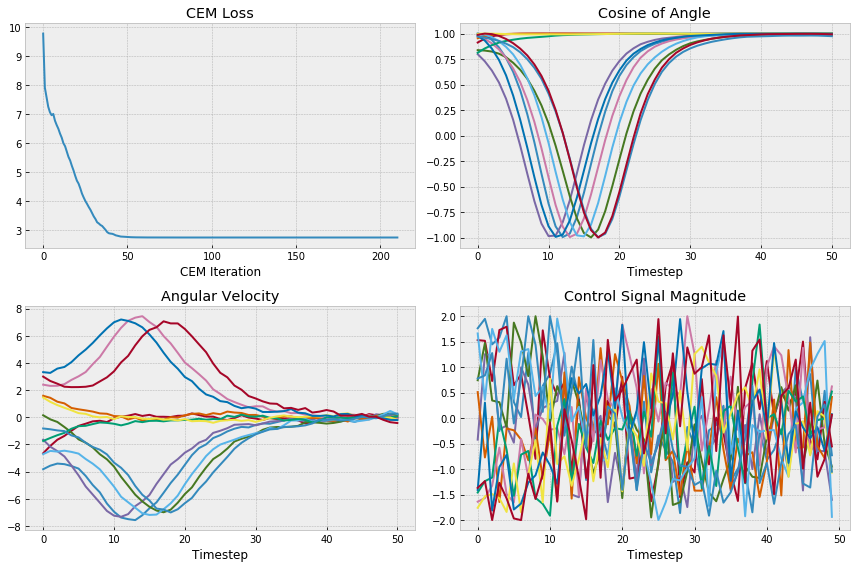

In [9]:
dx = PendulumDx() # Instantiate the pendulum dynamics

# Helper function that unrolls the dynamics given an initial system state
# and sequence of controls and returns the next sequence of states.
# This is not directly used by `dcem_ctrl`.
def unroll_dx(init_x, us):
    T = us.size(0)
    x = init_x
    xs = [x]
    for t in range(T):
        x = dx(x, us[t])
        xs.append(x)
    xs = torch.stack(xs)
    return xs

# Given an initial system state and sequence of controls,
# return the cost of the rollout.
# Our CEM-based controller seeks to find the control sequence
# to minimize this cost.
def rollout_cost(init_x, us):
    goal_state = torch.Tensor((1., 0. ,0.)) # Upright position
    xs = unroll_dx(init_x, us) # Get the state sequence of applying the controls
    assert xs.ndim == 3
    assert us.ndim == 3
    
    # Compute the squared Euclidean distance to the goal state
    # and add a penalty to encourage lower-valued controls.
    costs = (xs-goal_state).pow(2).mean(dim=[0,2]) + \
        1e-4*us.pow(2).mean(dim=[0,2])
    return costs
    
# Helper function that returns a sample from a uniform distribution
def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

# Randomly sample 12 initial system states
n_batch = 12
torch.manual_seed(0)
th = uniform(n_batch, -(1/4)*np.pi, (1/4)*np.pi)
thdot = uniform(n_batch, -4., 4.)
init_x = torch.stack((torch.cos(th), torch.sin(th), thdot), dim=1)

# Keep track of the CEM function values with the iteration callback.
fs = []
def iter_cb(i, X, fX, I, X_I, mu, sigma):
    fs.append(fX.mean())

# Solve the control problem. Here we assume perfect dynamics and
# just solve this problem once and report the induced state sequence.
# In practice, a CEM-based controllers are typically used online and
# re-solve the problem after observing new states so that the control
# sequence can be corrected if unexpected system transitions occur.
# When doing this, the CEM hyper-parameters will likely be different
# than what we have here.
dcem_out = dcem_ctrl(
    obs=init_x,
    plan_horizon=50, # Planning horizon for the control problem
    init_mu=0.0, # Initial control sequence mean, warm-starting can be done here
    init_sigma=3., # Initial variance around the control sequence
    n_sample=250,  # Number of samples CEM uses in each iteration
    n_elite=10, # Number of elite CEM candidates in each iteration
    n_iter=300, # Number of CEM iterations
    n_ctrl=dx.n_ctrl, # Number of control dimensions
    lb=dx.lower, # Lower-bound of the control signal
    ub=dx.upper, # Upper-bound of the control signal
    temp=None, # We use vanilla CEM here but can make it differentiable by setting a temp.
    rollout_cost=rollout_cost, # Function that returns the cost of rollout out a control sequence
    iter_cb=iter_cb, # CEM iteration callback
    dcem_iter_eps=1e-6, # CEM early-exit iteration threshold
)
opt_us = dcem_out['u']

# Unroll the optimal controls for analysis
xs = unroll_dx(init_x, opt_us)

nrow, ncol = 2, 2
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*6,nrow*4))
axs = axs.ravel()

ax = axs[0]
ax.plot(fs)
ax.set_xlabel('CEM Iteration')
ax.set_title('CEM Loss')

ax = axs[1]
for i in range(n_batch):
    ax.plot(xs[:,i,0].detach())
ax.set_xlabel('Timestep')
ax.set_title('Cosine of Angle')

ax = axs[2]
for i in range(n_batch):
    ax.plot(xs[:,i,2].detach())
ax.set_xlabel('Timestep')
ax.set_title('Angular Velocity')

ax = axs[3]
for i in range(n_batch):
    ax.plot(opt_us[:,i,0].detach())
ax.set_xlabel('Timestep')
ax.set_title('Control Signal Magnitude')

fig.tight_layout()

Lastly we can plot out the optimal state sequences found by CEM

In [10]:
t_dir = 'plots'
shutil.rmtree(t_dir)
os.makedirs(t_dir, exist_ok=True)

for t in range(xs.shape[0]):
    xt = xs[t]
    n_row, n_col = 3, 4
    fig, axs = plt.subplots(n_row, n_col, figsize=(3*n_col,3*n_row), gridspec_kw = {'wspace':0, 'hspace':0})
    axs = axs.reshape(-1)
    for i in range(n_batch):
        dx.get_frame(xt[i], ax=axs[i])
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    fig.tight_layout()
    fname = os.path.join(t_dir, '{:03d}.png'.format(t))
    fig.savefig(fname)
    plt.close(fig)
    os.system(f'convert {fname} -trim {fname}')

os.system('convert plots/*.png +repage pendulum.gif')
shutil.rmtree('plots')
from IPython.display import Image
Image(url='pendulum.gif')